In [1]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from nilearn import image



/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'
import sys
sys.path.insert(0,git_dir)

import HAP_Utils as hap

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Get hippocampus samples

In [4]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
#df =  pandas.read_csv(os.path.join(wdir,'MAIN_ALLVAR_hippocampus_sample_info.csv'), index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
#gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [312]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

# Cognitive fmri meta-analysis

Collect all 100 reverse inference maps downloaded from Neurosynth

In [5]:
metascans = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/r*.nii.gz'))
print(len(metascans))
metascans[0]

100


'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/rv4-topics-100_0_stimulation_somatosensory_tms_pFgA_z_FDR_0_img.nii.gz'

In [6]:
# Assign labels to the maps describing the topic number, the first two words, and the image type (pFgA) 
metalabs = ['T%s_%s_%s_%s'%(os.path.split(x)[-1].split('_')[1],
                         os.path.split(x)[-1].split('_')[3],
                            os.path.split(x)[-1].split('_')[4],
                         os.path.split(x)[-1].split('_')[-5]) for x in metascans]
metares_a = pandas.DataFrame(index=gdf.index,columns = metalabs)
#metares_a.columns = metalabs
metares_a.shape

(3702, 100)

In [7]:
# Load all maps at once (might give trouble to slow computers, takes a few moments on fast computers)
allmetas = image.load_img(metascans).get_data()

Here, we are interested in which samples overlap with each map. Once we figure out which samples overlap with the map, we average the value of all samples within a map to get a single value representing the average HAGS index of regions falling within each map

In [13]:
col = 'AP_axis_gxp_signature_similarity_SPCR'

# for each coordinate
for i,row in gdf.iterrows():
    # draw a 5mm cube around the coordinate
    xs,ys,zs = hap.make_sphere(hap.convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz'), 3)
    # for each image
    for img in range(allmetas.shape[-1]):
        # if there is any data inside the cube (i.e. if the sample falls within the map)
        if allmetas[xs,ys,zs,img].mean() > 0:
            # add data for this sample to spreadsheet (i.e. mark this sample as within the map)
            metares_a.loc[i,metalabs[img]] = row[col]
    if i%100 == 0:
        print('finished %s of 3702'%i)

finished 0 of 3702
finished 100 of 3702
finished 200 of 3702
finished 300 of 3702
finished 400 of 3702
finished 500 of 3702
finished 600 of 3702
finished 700 of 3702
finished 800 of 3702
finished 900 of 3702
finished 1000 of 3702
finished 1100 of 3702
finished 1200 of 3702
finished 1300 of 3702
finished 1400 of 3702
finished 1500 of 3702
finished 1600 of 3702
finished 1700 of 3702
finished 1800 of 3702
finished 1900 of 3702
finished 2000 of 3702
finished 2100 of 3702
finished 2200 of 3702
finished 2300 of 3702
finished 2400 of 3702
finished 2500 of 3702
finished 2600 of 3702
finished 2700 of 3702
finished 2800 of 3702
finished 2900 of 3702
finished 3000 of 3702
finished 3100 of 3702
finished 3200 of 3702
finished 3300 of 3702
finished 3400 of 3702
finished 3500 of 3702
finished 3600 of 3702
finished 3700 of 3702


In [14]:
# calculate the size of each map
map_sizes = []
for i in range(allmetas.shape[-1]):
    jnk = allmetas[:,:,:,i]
    map_sizes.append(len(jnk[jnk>0]))

In [15]:
# we don't need the image data anymore, so let's get rid of it (its taking up a lot of memory)
del(allmetas)

In [16]:
# calculate the number of samples found within each map
map_hits = []
for col in metares_a.columns:
    jnk = metares_a[col]
    map_hits.append(len([x for x in jnk.values if pandas.notnull(x)]))

In [17]:
# create a spreadsheet summarizing all of the relevant information

# create spreadsheet
res_sum = pandas.DataFrame(index = metares_a.columns)
res_sum.loc[:,'mean'] = metares_a.mean().values # average HAGS index of samples within map
res_sum.loc[:,'sem'] = metares_a.sem().values # SEM of HAGS index of samples within map
res_sum.loc[:,'map_size'] = map_sizes # size (in voxels) of each map
res_sum.loc[:,'map_hits'] = map_hits # number of samples falling within each map

In [18]:
res_sum.sort_values('mean').head()

,mean,sem,map_size,map_hits
T29_delayed_roi_pFgA,-0.062083,0.007179,1848,20
T93_eyes_movements_pFgA,-0.039965,0.002010,146429,398
T9_attentional_visual_pFgA,-0.032526,0.002561,107198,221
T88_perception_visual_pFgA,-0.032333,0.003025,92493,178
T36_auditory_sensory_pFgA,-0.031379,0.002618,102886,327


In [19]:
# Just in case someone asks for it, create a new mean weighted by number of samples in each map
cols = ['mean','sem']
for col in cols:
    wtd = (res_sum[col].values * res_sum.map_hits.values
          ) / (res_sum[col].values + res_sum.map_hits.values)
    res_sum.loc[:,'wtd_%s'%col] = wtd

In [20]:
res_sum.sort_values('mean').head()

,mean,sem,map_size,map_hits,wtd_mean,wtd_sem
T29_delayed_roi_pFgA,-0.062083,0.007179,1848,20,-0.062276,0.007177
T93_eyes_movements_pFgA,-0.039965,0.002010,146429,398,-0.039969,0.002010
T9_attentional_visual_pFgA,-0.032526,0.002561,107198,221,-0.032530,0.002561
T88_perception_visual_pFgA,-0.032333,0.003025,92493,178,-0.032339,0.003025
T36_auditory_sensory_pFgA,-0.031379,0.002618,102886,327,-0.031382,0.002618


In [22]:
# How many (of the 100 maps) actually overlap with some samples?
goodlabs = metares_a.mean().dropna().index
len(goodlabs)

90

In [23]:
# Get rid of those that don't and sort data
metaresb = metares_a[goodlabs]
metaresb = metaresb[metaresb.mean().sort_values().index]

Here, we apriori identify to topic sets that we feel should overlap with the AT or PM system, based on comparing the words in the topic lists with the descriptions of the AT/PM systems in Ranganath and Ritchey (2012)

In [24]:
# Identify topics for each system
ATLabs = ['T65','T60','T17','T20','T90']
PMLabs = ['T56','T24','T40','T14','T75']

# parse topic number and add system to relevant topics
for top in res_sum.index:
    tnum = top.split('_')[0]
    if tnum in ATLabs:
        res_sum.loc[top,'system'] = 'AT'
    elif tnum in PMLabs:
        res_sum.loc[top,'system'] = 'PM'
res_sum2 = res_sum.loc[metaresb.columns]

Here, we get only retain samples that have at least 400 samples, to ensure we are not getting enough data

In [30]:
goodlabs = res_sum[res_sum.map_hits>400].index
len(goodlabs)
metares400 = metares_a[goodlabs]
metares400 = metares400[metares400.mean().sort_values().index]

In [31]:
# How many maps does that leave us with?
res_sum4 = res_sum.loc[metares400.columns]
res_sum4.shape

(27, 7)

Finally, we plot the results. We would like to see the mean (and SEM) HAGS index of samples falling within maps overlapping with at least 400 samples. We want values in the AT and PM system to be color coded. 

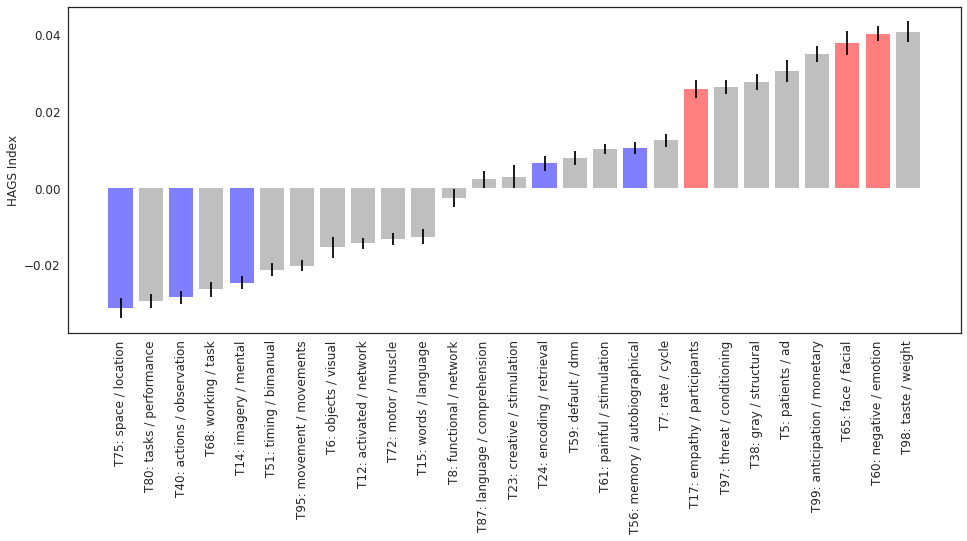

In [32]:
sns.set_context('notebook',font_scale=2)

# get mean and SEM data
means = (metares400.mean()).tolist()
stds = metares400.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

# get labels
xlabs = ['%s: %s / %s'%(x.split('_')[0],
                x.split('_')[1],
                x.split('_')[2]) for x in metares400.mean().dropna().index.tolist()]

# get the range of the confidence interval
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

# color code AT and PM bars
colors = ['red' if res_sum4.loc[x,'system'] == 'AT' else 'blue' if res_sum4.loc[x,'system'] == 'PM' else 'gray' for x in metares400.columns]

# Make a barplot
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,6))
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = colors,
             )
ax.set_xticks(range(len(means)))
ax.set_xticklabels(xlabs, rotation=90)
ax.set_ylabel('HAGS Index')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/COG_t100_s100_horiz.pdf')
plt.show()

Here is the same thing, but vertical...

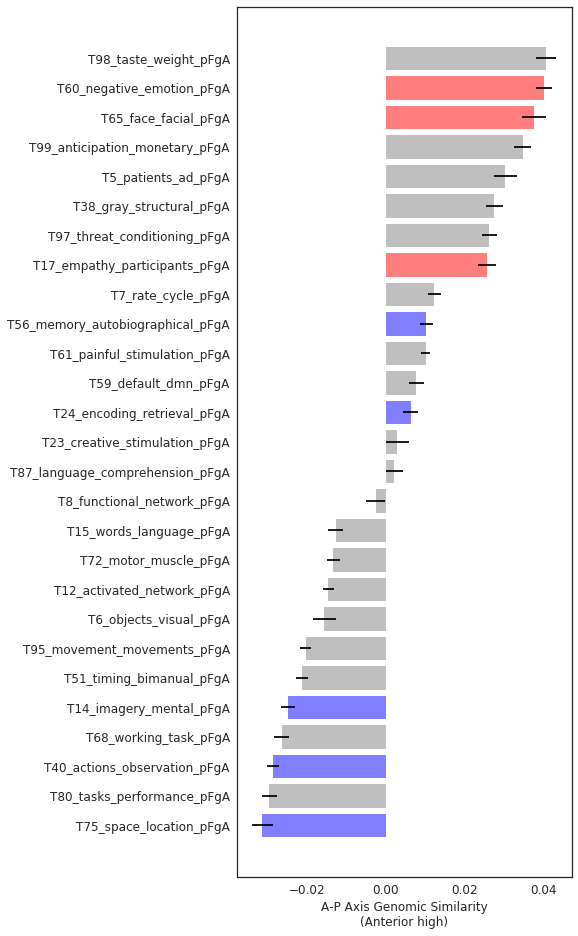

In [33]:
means = (metares400.mean()).tolist()
stds = metares400.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum4.loc[x,'system'] == 'AT' else 'blue' if res_sum4.loc[x,'system'] == 'PM' else 'gray' for x in metares400.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,16))
fig = plt.barh(range(len(means)), means, xerr=y_r, alpha=0.5, align='center', color = colors,
             )
ax.set_yticks(range(len(means)))
ax.set_yticklabels(metares400.mean().dropna().index.tolist())
ax.set_xlabel('A-P Axis Genomic Similarity\n(Anterior high)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/COG_ALL_s400.pdf', bbox_inches = 'tight')
plt.show()

#### Repeating analysis with maps overlapping with at least 100 samples (instead of 400)
I put all of the above in a handy pipeline so plots can be generated easily

>>>Calculating stuff<<<
90 maps did not overlap with any samples
>>>removing data with less than 100 samples overlapping
54 maps remaining
>>>plotting<<<


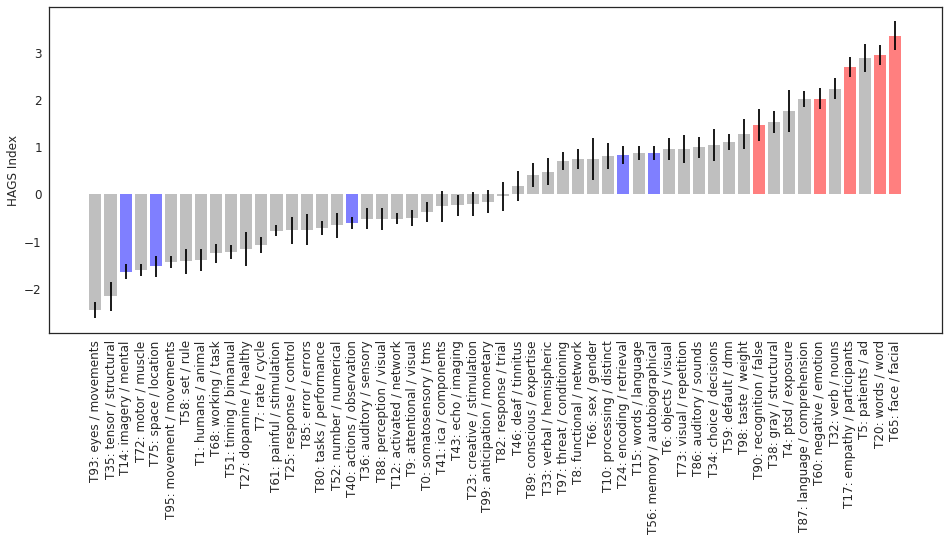

In [9]:
c_res = hap.cognitive_metaanalysis_pipeline(metares=metares_a, min_samples=100)

#### Repeat original analysis, but this time from scratch and using only Gene Set1 instead of all genes 

In [7]:
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))

>>>loading data<<<
>>>computing overlap of each sample with each map<<<
finished 0 of 3702
finished 100 of 3702
finished 200 of 3702
finished 300 of 3702
finished 400 of 3702
finished 500 of 3702
finished 600 of 3702
finished 700 of 3702
finished 800 of 3702
finished 900 of 3702
finished 1000 of 3702
finished 1100 of 3702
finished 1200 of 3702
finished 1300 of 3702
finished 1400 of 3702
finished 1500 of 3702
finished 1600 of 3702
finished 1700 of 3702
finished 1800 of 3702
finished 1900 of 3702
finished 2000 of 3702
finished 2100 of 3702
finished 2200 of 3702
finished 2300 of 3702
finished 2400 of 3702
finished 2500 of 3702
finished 2600 of 3702
finished 2700 of 3702
finished 2800 of 3702
finished 2900 of 3702
finished 3000 of 3702
finished 3100 of 3702
finished 3200 of 3702
finished 3300 of 3702
finished 3400 of 3702
finished 3500 of 3702
finished 3600 of 3702
finished 3700 of 3702
>>>Calculating stuff<<<
90 maps did not overlap with any samples
>>>removing data with less than 400 sam

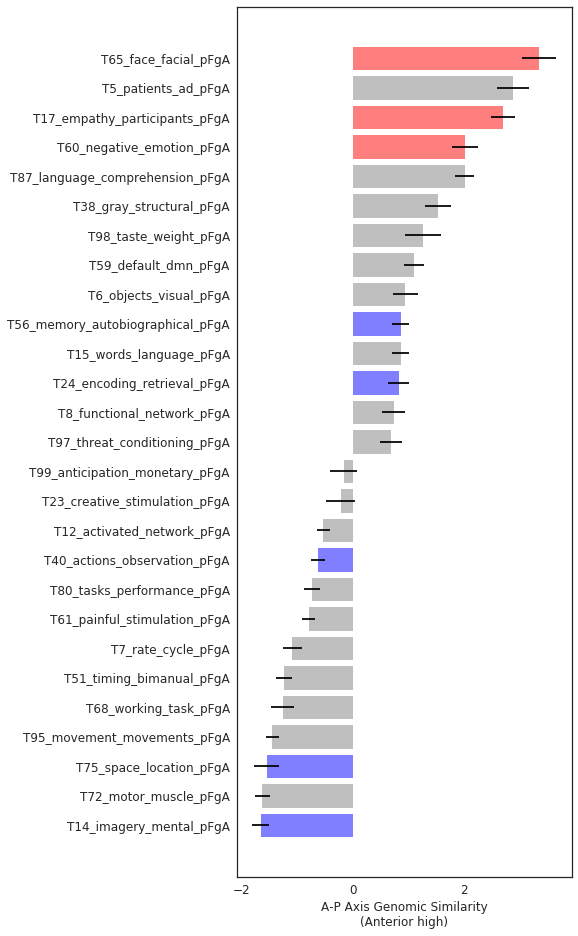

In [8]:
c_res = hap.cognitive_metaanalysis_pipeline(scans = metascans, gdf = gdf, target_col = 'vec100',
                               labels = metalabs, figtype = 'vertical')